In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import re
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load data from CSV
data = pd.read_csv('/kaggle/input/hindidataset/HindiNews/HindiNews_train_v2/hindi_train.csv')

In [5]:
# ANALYZE DATASETS
data.head()

,Id,Heading,Summary,Article
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...


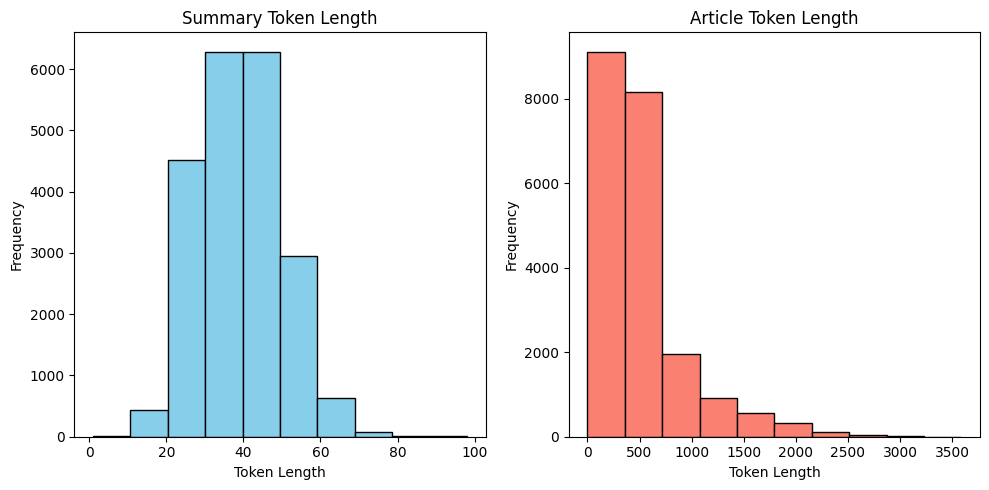

In [8]:
import matplotlib.pyplot as plt
df=data
# Tokenize the summary and article columns using split(" ")
df['summary_tokens'] = df['Summary'].apply(lambda x: x.split(" "))
df['article_tokens'] = df['Article'].apply(lambda x: x.split(" "))

# Calculate the token length (number of tokens)
df['summary_token_length'] = df['summary_tokens'].apply(len)
df['article_token_length'] = df['article_tokens'].apply(len)

# Plotting separate graphs for summary and article token lengths
plt.figure(figsize=(10, 5))

# Summary token length plot
plt.subplot(1, 2, 1)
plt.hist(df['summary_token_length'], color='skyblue', edgecolor='black')
plt.title('Summary Token Length')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# Article token length plot
plt.subplot(1, 2, 2)
plt.hist(df['article_token_length'], color='salmon', edgecolor='black')
plt.title('Article Token Length')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
df.head()

,Id,Heading,Summary,Article,summary_tokens,article_tokens,summary_token_length,article_token_length
0,hindi_2023_train_0,"गला दबाकर हत्या की; बॉडी बोरे में भरी, लोकल मा...",Kerala Minor Girl Rape Case - केरल के एर्नाकुल...,केरल के एर्नाकुलम जिले में 5 साल की बच्ची से र...,"[Kerala, Minor, Girl, Rape, Case, -, केरल, के,...","[केरल, के, एर्नाकुलम, जिले, में, 5, साल, की, ब...",38,288
1,hindi_2023_train_1,तेलंगाना में 18 की जान गई; जम्मू-कश्मीर में बा...,इस साल मानसून सीजन में कई राज्यों में भारी तबा...,मानसून सीजन में हुई भारी बारिश ने कई राज्यों म...,"[इस, साल, मानसून, सीजन, में, कई, राज्यों, में,...","[मानसून, सीजन, में, हुई, भारी, बारिश, ने, कई, ...",59,162
2,hindi_2023_train_2,"राजस्थान सरकार बनाएगी कर्ज राहत आयोग, कोर्ट के...",चुनावी साल में राजस्थान सरकार किसानों को लुभान...,चुनावी साल में राजस्थान सरकार किसानों को लुभान...,"[चुनावी, साल, में, राजस्थान, सरकार, किसानों, क...","[चुनावी, साल, में, राजस्थान, सरकार, किसानों, क...",53,781
3,hindi_2023_train_3,"3 से 7 अगस्त तक कर सकेंगे अप्लाय, प्राइस बैंड ...",Non-banking lender SBFC Finance's initial publ...,नॉन बैंकिग फाइनेंस कंपनी 'SBFC फाइनेंस लिमिटेड...,"[Non-banking, lender, SBFC, Finance's, initial...","[नॉन, बैंकिग, फाइनेंस, कंपनी, 'SBFC, फाइनेंस, ...",36,339
4,hindi_2023_train_4,"डाइनिंग टेबल पर कुकर-कड़ाही न सजाएं, चीन के खा...",स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,स्वाद खाने की बुनियाद है। लेकिन अगर खाना सुंदर...,"[स्वाद, खाने, की, बुनियाद, है।, लेकिन, अगर, खा...","[स्वाद, खाने, की, बुनियाद, है।, लेकिन, अगर, खा...",45,1133


In [ ]:
data.iloc[0,3]

In [ ]:
def get_sentence_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        sentence = re.sub(r'\n', '', sentence)
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True).to(device)
        outputs = model(**inputs)
        sentence_embedding = torch.mean(outputs.last_hidden_state, dim=1)
        embeddings.append(sentence_embedding.cpu().detach().numpy())  # Detach the tensor from the graph
    return np.concatenate(embeddings, axis=0)  # Concatenate numpy arrays

# Compute similarity between sentences and summaries
similarities = []
for i, row in tqdm(data.iterrows()):
    summary_embedding = get_sentence_embeddings([row['Heading']])[0]
    article_sentences = row['Article'].split('।')
    article_embeddings = get_sentence_embeddings(article_sentences)
    similarity_scores = cosine_similarity(article_embeddings, summary_embedding.reshape(1, -1))
    similarities.append(similarity_scores)

In [ ]:
with open('similarities.pkl', 'wb') as f:
    pickle.dump(similarities, f)

# Training Custom Transformer

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# Define the dataset
class HindiDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article, summary, heading = self.data[idx]
        article_tokens = self.tokenizer(article, return_tensors="pt", padding=True, truncation=True).input_ids
        summary_tokens = self.tokenizer(summary, return_tensors="pt", padding=True, truncation=True).input_ids
        heading_tokens = self.tokenizer(heading, return_tensors="pt", padding=True, truncation=True).input_ids
        return article_tokens, summary_tokens, heading_tokens

# Define the transformer model
class Transformer(nn.Module):
    def __init__(self, roberta_model, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_len):
        super(Transformer, self).__init__()
        self.roberta = roberta_model
        self.encoder = nn.Transformer(d_model, nhead, num_encoder_layers, dim_feedforward, batch_first=True)
        self.decoder = nn.Transformer(d_model, nhead, num_decoder_layers, dim_feedforward, batch_first=True)
        self.out = nn.Linear(d_model, roberta_model.config.vocab_size)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        self.pos_decoder = PositionalEncoding(d_model, max_len=max_len)

    def forward(self, src, tgt, src_pad_mask=None, tgt_pad_mask=None, tgt_mask=None):
        src_embeddings = self.roberta(src)[0]
        tgt_embeddings = self.roberta(tgt)[0]
        src = self.pos_encoder(src_embeddings)
        tgt = self.pos_decoder(tgt_embeddings)
        encoder_output = self.encoder(src, src_key_padding_mask=src_pad_mask)
        decoder_output = self.decoder(tgt, encoder_output, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask)
        output = self.out(decoder_output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

dataset = [
    ("यह एक हिंदी लेख है।", "यह एक सारांश है।", "यह एक शीर्षक है।"),
    ("यह एक और हिंदी लेख है।", "यह एक और सारांश है।", "यह एक और शीर्षक है।"),
    # ... more examples
]

# Create the dataset and data loader
hindi_dataset = HindiDataset(dataset)
dataloader = DataLoader(hindi_dataset, batch_size=32, shuffle=True)

# Load the pre-trained XLM-RoBERTa model
roberta_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
tokenizer = hindi_dataset.tokenizer

# Initialize the model
d_model = roberta_model.config.hidden_size
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_len = 100  # Maximum sequence length
model = Transformer(roberta_model, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_len)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for article_tokens, summary_tokens, heading_tokens in dataloader:
        src = article_tokens.squeeze(1)
        tgt = summary_tokens.squeeze(1)
        output = model(src, tgt[:, :-1], src_pad_mask=None, tgt_pad_mask=None, tgt_mask=None)
        loss = criterion(output.view(-1, roberta_model.config.vocab_size), tgt[:, 1:].contiguous().view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# Initialize the model
embedding_matrix = hindi_dataset.embedding_matrix
d_model = embedding_matrix.shape[1]  # Assuming embedding dimensionality is d_model
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_len = 100  # Maximum sequence length
model = Transformer(embedding_matrix, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_len)